In [1]:
from random import random, setstate, getstate
from math import e, log as ln
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# def factorial(x: int, _cache={}) -> int:
#     if x >= 0:
#         if x in _cache:
#             return _cache[x]
#         val = reduce(int.__mul__, range(1, x+1), 1)
#         _cache[x] = val
#         return val

# def pois(k: int, param: float = 1):
#     """If X ~ Po(param), returns P(X = k); PDF(k)"""
#     if param > 0 and type(k) is int and k >= 0:
#         return e**-param * param**k / factorial(k)


# def qpois(k: float, param: float = 1):
#     """If X ~ Po(param), returns P(X <= k); CDF(k)"""
#     if param > 0 and type(k) is int:
#         return e**-param * sum(param**i / factorial(i) for i in range(int(k)))


# def exp(k: float, param: float = 1):
#     """If X ~ Exp(param), returns P(X = k)"""
#     if param > 0 and type(k) in {float, int}:
#         return param * e**(-param*k) if k >= 0 else 0


# def qexp(k: float, param: float = 1):
#     """If X ~ Exp(param), returns P(X <= k)"""
#     if param > 0 and type(k) in {float, int}:
#         return 1 - e**(-param*k) if k >= 0 else 0

In [3]:
def rpois(n: int = 1, param: float = 1, rng=random):
    """Poisson generator based upon the inversion by sequential search from (https://en.wikipedia.org/wiki/Poisson_distribution#Random_variate_generation)"""
    r = []
    for _ in range(n):
        x = 0
        p = e**-param
        s = p
        u = rng()
        while u > s:
            x += 1
            p *= param/x
            s += p
        r.append(x)
    return r


def rexp(n: int = 1, param: float = 1, rng=random):
    return [-ln(u)/param for u in (rng() for _ in range(n))]

In [4]:
class Insurance():

    __ruin_warning = False

    def __init__(self, u: float, c: float, arr_rate: float, amt_rate: float, inv_rng: bool = False, initial_state=None) -> None:
        self.u = u
        self.c = c
        self.arr_rate = arr_rate
        self.amt_rate = amt_rate
        self.x = u
        self.claims_received = 0
        self.max_capital = u
        self.min_capital = u
        self._time = 0
        self._ruined = False
        self.traj = []
        if initial_state is None:
            self._initial_state = getstate()
        else:
            self._initial_state = initial_state
            setstate(initial_state)
        if inv_rng == False:
            self.rng = random
        else:
            self.rng = lambda: 1 - random()

    def __iadd__(self, delta_t: int) -> None:
        # if the company is ruined don't do anything
        if self._ruined:
            return self

        for _ in range(delta_t):
        # debug
        #   print(f"{self._time:>5}\t+{self.c:>15,.2f}")
        #   last_x = self.x
        #
            # claims
            claim_amt = rpois(param=self.arr_rate, rng=self.rng)[0]
            dt = 1/(claim_amt+1)
            for _ in range(claim_amt):
                claim = rexp(param=self.amt_rate, rng=self.rng)[0]
                self.x -= claim
                self._time += dt
                self.traj.append((self._time, self.x))

            # debug
            #   print(f"{self._time:>5}\t-{(last_x-self.x)/claim_amt:>15,.2f}")
            #

                # updating internal vars
                self.max_capital = max(self.x, self.max_capital)
                self.min_capital = min(self.x, self.min_capital)
                if self.x <= 0:
                    self.ruin()
                    break

                

            self._time = round(self._time)

            # premiums
            self.x += self.c
            self.traj.append((self._time, self.x))

        # debug
        #   print(f"{self._time:>5}\t-{(last_x-self.x)/claim_amt:>15,.2f}")
        #

        return self

    def ruin(self):
        self._ruined = True
        if Insurance.__ruin_warning:
            print(f"""\
    The company is ruined!!
    It survived {self._time} days and ended up with a capital of ${self.x:,.2f}.
    The highest capital achieved was ${self.max_capital:,.2f},
    The lowest capital recorded was ${self.min_capital:,.2f}""")

    def __str__(self) -> str:
        return f"""\
The company has survived for {self._time} days and has a current capital of ${self.x:,.2f}.
The highest capital achieved yet is ${self.max_capital:,.2f},
The lowest capital recorded yet is ${self.min_capital:,.2f}"""


In [5]:
proportions_over_time = []
failures = 0
n = 500
time = 10000

for i in range(1, n+1):
    I = Insurance(14_000_000, 2_290_000, 74.241, 3.25e-5)
    for _ in range(time):
        I += 1
        
    failures += I._ruined
    proportions_over_time.append(failures/i)

    #traj = pd.DataFrame(I.traj)

    #plt.plot(traj[0], traj[1])
    #plt.ylim(0, I.max_capital*1.03)
    #plt.xlim(0, I._time*1.01)
    #print(f"{I.max_capital=}\n{I.min_capital=}")

    print('\r',i, end='')

 500

In [6]:
p = failures/n
print(f"Crude Monte Carlo with {n} samples until time = {time}")
print(f'\rfailure rate: {p:.2%}')
print(f'10% confidence interval: [{p - 1.96*(p*(1-p)/n)**.5:.2%}, {p + 1.96*(p*(1-p)/n)**.5:.2%}]')

Crude Monte Carlo with 500 samples until time = 10000
failure rate: 36.00%
10% confidence interval: [31.79%, 40.21%]


In [7]:
# antithetic vars
import math
# estimation of number of trials at 5% of +-5%
z = 1.65
E = 0.05

n_ = z**2*p*(1-p)/E**2

# round to the nearest 10th
n_ = math.ceil(n_/10)*10

failures_ = 0
proportions_over_time_ = []

for i in range(1, n_+1, 2):
    
    # first run
    I = Insurance(14_000_000, 2_290_000, 74.241, 3.25e-5)
    for _ in range(time):
        I += 1

    failures_ += I._ruined
    proportions_over_time_.append(failures_/i)

    # second run
    i += 1
    I_ = Insurance(14_000_000, 2_285_016, 74.241, 3.25e-5, inv_rng = True, initial_state = I._initial_state)
    for _ in range(time):
        I_ += 1

    failures_ += I_._ruined
    proportions_over_time_.append(failures_/i)

    print('\r',i, end='')

 260

In [8]:
p_ = failures_/n_
print(f"Variance Reduction Monte Carlo with {n_} samples until time = {time}")
print(f'\rfailure rate: {p_:.2%}')
print(f'5% confidence interval: [{p_ - 1.65*(p_*(1-p_)/n_)**.5:.2%}, {p_ + 1.65*(p_*(1-p_)/n_)**.5:.2%}]')

Variance Reduction Monte Carlo with 260 samples until time = 10000
failure rate: 55.38%
5% confidence interval: [50.30%, 60.47%]


Text(0, 0.5, 'Probabilidad')

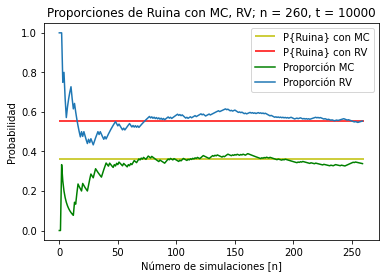

In [9]:
# a, b = 0, 25*365
# zoom = traj[(a <= traj[0]) & (traj[0] <= b)]

# plt.plot(zoom[0], zoom[1])
# plt.ylim(min(zoom[1])*0.97, max(zoom[1])*1.03)
# plt.xlim(zoom[0].iloc[0], zoom[0].iloc[-1])

# # other plot
# plt.plot(traj[0]/365, traj[1])
plt.hlines(p, 0, n_, colors='y')
plt.hlines(p_, 0, n_, colors='red')

plt.plot(proportions_over_time[:n_], color = 'g')

plt.plot(proportions_over_time_)


plt.title(f"Proporciones de Ruina con MC, RV; n = {n_}, t = {time}")
plt.legend(['P{Ruina} con MC', 'P{Ruina} con RV', 'Proporción MC', 'Proporción RV'])
plt.xlabel('Número de simulaciones [n]')
plt.ylabel('Probabilidad')

Text(0, 0.5, 'Probabilidad')

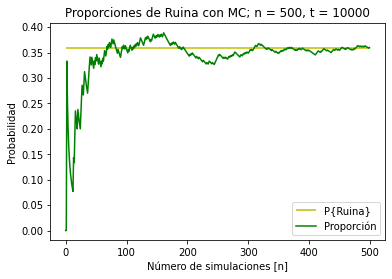

In [10]:
plt.hlines(p, 0, n, colors='y')
plt.plot(proportions_over_time, color = 'g')
plt.title(f"Proporciones de Ruina con MC; n = {n}, t = {time}")
plt.legend(['P{Ruina}', 'Proporción'], loc = 'lower right')
plt.xlabel('Número de simulaciones [n]')
plt.ylabel('Probabilidad')